## Introduction
Image classification is a fundamental task in computer vision with applications in autonomous systems, medical imaging, and e-commerce. This study aims to evaluate the performance of three different Convolutional Neural Networks (CNNs) in classifying images of dogs and cats. The models implemented include a Simple CNN, a Deeper CNN, and a VGG16 Transfer Learning model. The Simple CNN consists of a basic architecture with convolutional and pooling layers. The Deeper CNN incorporates additional convolutional layers, batch normalization, and dropout for improved generalization. The VGG16 Transfer Learning model leverages a pre-trained VGG16 network with fine-tuning tailored for dog vs. cat classification. This study evaluates model performance using training and validation accuracy, loss curves, confusion matrices, and Receiver Operating Characteristic (ROC) curves.

## Data Load / Libraries Load

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

In [2]:
# 1. Extract ZIP Files in Google Colab
# Extract ZIP files if not already extracted
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"Extracting {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall("/content/")  # Extract in Colab workspace
    else:
        print(f"{extract_to} already exists, skipping extraction.")

extract_zip("train.zip", "train")
extract_zip("test.zip", "test")

train already exists, skipping extraction.
test already exists, skipping extraction.


## Data Presentation

In [3]:
# 2. Load Training Data
train_images = glob.glob(os.path.join("train", "*.jpg"))
train_labels = ["dog" if 'dog' in os.path.basename(img) else "cat" for img in train_images]

# Create DataFrame for training data
train_df = pd.DataFrame({
    'image_path': train_images,
    'label': train_labels
})

# Display dataset info
print("Train Dataset:")
print(train_df.head())

Train Dataset:
            image_path label
0   train/cat.5199.jpg   cat
1  train/cat.10279.jpg   cat
2  train/cat.11624.jpg   cat
3  train/dog.12363.jpg   dog
4   train/dog.7036.jpg   dog


In [4]:
# 3. Load Test Data
test_images_filenames = sorted(glob.glob(os.path.join("test", "*.jpg")))

test_images = []
test_ids = []  # Store image IDs for submission

for img_path in test_images_filenames:
    img = cv2.imread(img_path)  # Load image
    img = cv2.resize(img, (150, 150))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values
    test_images.append(img)
    test_ids.append(int(os.path.basename(img_path).split(".")[0]))  # Extract ID

test_images = np.array(test_images)
test_ids = np.array(test_ids)

## EDA of Initial Dataset

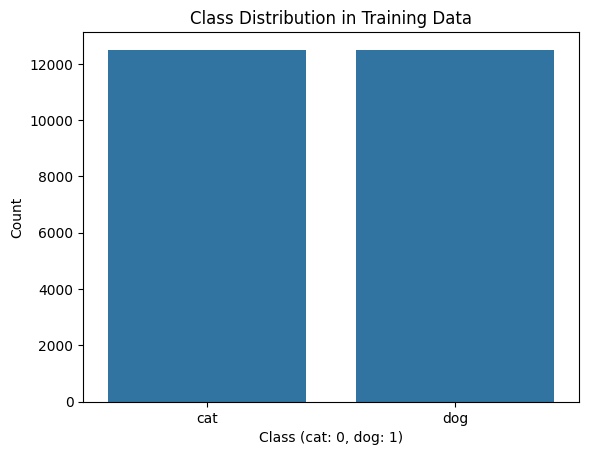

In [5]:
# 4. Exploratory Data Analysis (EDA)
sns.countplot(x=train_df['label'])
plt.title("Class Distribution in Training Data")
plt.xlabel("Class (cat: 0, dog: 1)")
plt.ylabel("Count")
plt.show()

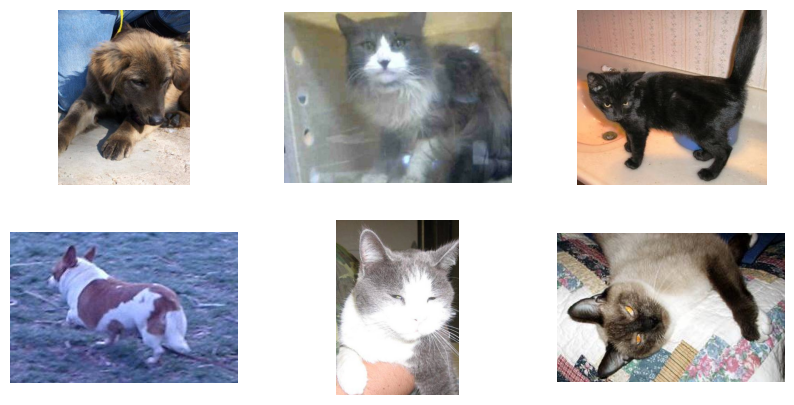

In [6]:
# Show example images
import random
from PIL import Image
sample_images = random.sample(list(train_df["image_path"]), 6)
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

## Data Preprocessing and Feature Engineering

In [7]:
# 5. Data Preprocessing
X_train, X_val, y_train, y_val = train_test_split(train_df['image_path'], train_df['label'], test_size=0.2, random_state=42)
train_df = pd.DataFrame({'image_path': X_train, 'label': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'label': y_val})

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='image_path', y_col='label',
    target_size=(150, 150), batch_size=32, class_mode='binary')

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='image_path', y_col='label',
    target_size=(150, 150), batch_size=32, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Overview of the Steps to Be Completed and the Rationale
 - Experimental Setup: The models implemented include a Simple CNN (2 convolutional layers), a Deeper CNN (3 convolutional layers), and a VGG16 Transfer Learning model.

 - Model Training and Optimization: For each experiment, we train the model for 10 epochs with learning rate of 0.0001, batch size of 32.

 - Model Evaluation: Each trained model is evaluated based on Validation Accuracy, Loss Curves, Confusion Matrix, and ROC Curve and Precision-Recall Curve.

## Model Training (including cross-validation, testing, and evaluation)

In [8]:
# 6. Model Training
def build_simple_cnn():
    model = models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_deeper_cnn():
    model = models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16_transfer_learning():
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

models_list = {
    "Simple_CNN": build_simple_cnn(),
    "Deeper_CNN": build_deeper_cnn(),
    "VGG16_Transfer": build_vgg16_transfer_learning()
}

models_list = {
    "Simple_CNN": build_simple_cnn(),
    "Deeper_CNN": build_deeper_cnn(),
    "VGG16_Transfer": build_vgg16_transfer_learning()
}

history_dict = {}

In [9]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy Curve")
    plt.legend()
    plt.show()

def plot_training_curves(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

def plot_confusion_matrix(model, val_generator, model_name):
    y_true = val_generator.classes
    y_pred = model.predict(val_generator) > 0.5
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

def plot_roc_curve(model, val_generator, model_name):
    y_true = val_generator.classes
    y_pred_prob = model.predict(val_generator)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()


Training Simple_CNN...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.5637 - loss: 0.7603 - val_accuracy: 0.7358 - val_loss: 0.5613
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7191 - loss: 0.5560 - val_accuracy: 0.7126 - val_loss: 0.5460
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7574 - loss: 0.5103 - val_accuracy: 0.7750 - val_loss: 0.4859
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7804 - loss: 0.4691 - val_accuracy: 0.7648 - val_loss: 0.4888
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7950 - loss: 0.4530 - val_accuracy: 0.7884 - val_loss: 0.4587
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8124 - loss: 0.4191 - val_accuracy: 0.7868 - val_loss: 0.4609
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8254 - loss: 0.3950 - val_accuracy: 0.7898 - val_loss: 0.4561
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8424 - loss: 0.3632 - val_accurac

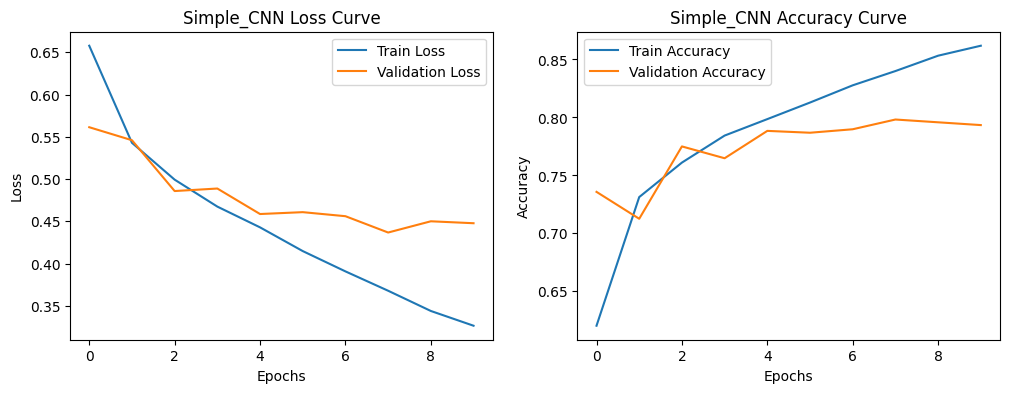

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


<Figure size 600x500 with 0 Axes>

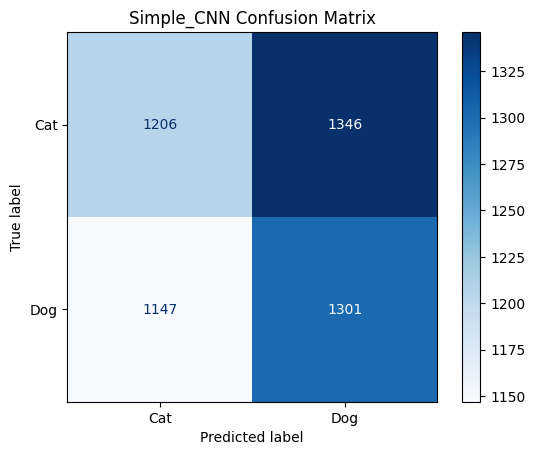

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


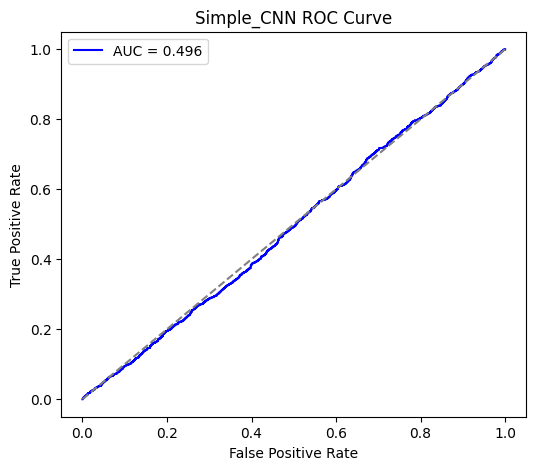

Training Deeper_CNN...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.6039 - loss: 0.6486 - val_accuracy: 0.7418 - val_loss: 0.5291
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7570 - loss: 0.5053 - val_accuracy: 0.7790 - val_loss: 0.4695
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7869 - loss: 0.4521 - val_accuracy: 0.7948 - val_loss: 0.4425
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8070 - loss: 0.4195 - val_accuracy: 0.8126 - val_loss: 0.4162
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.8225 - loss: 0.3941 - val_accuracy: 0.8150 - val_loss: 0.3982
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8363 - loss: 0.3722 - val_accuracy: 0.8184 - val_loss: 0.3980
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8435 - loss: 0.3512 - val_accuracy: 0.8342 - val_loss: 0.3737
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0

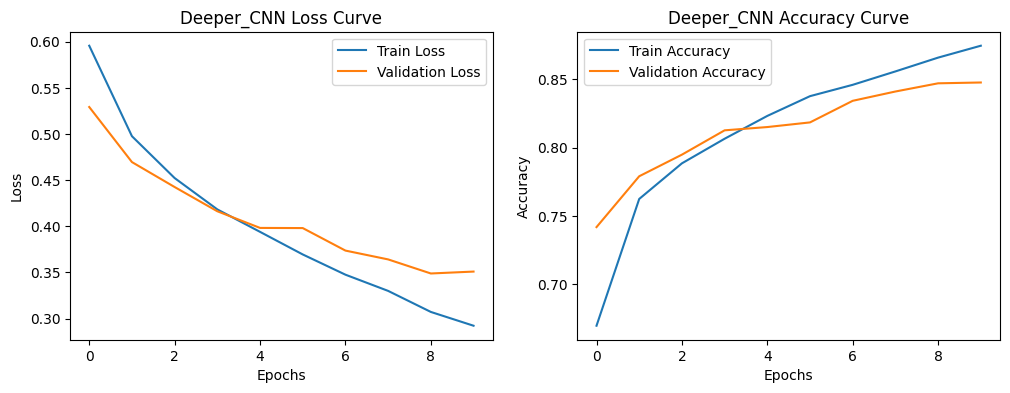

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


<Figure size 600x500 with 0 Axes>

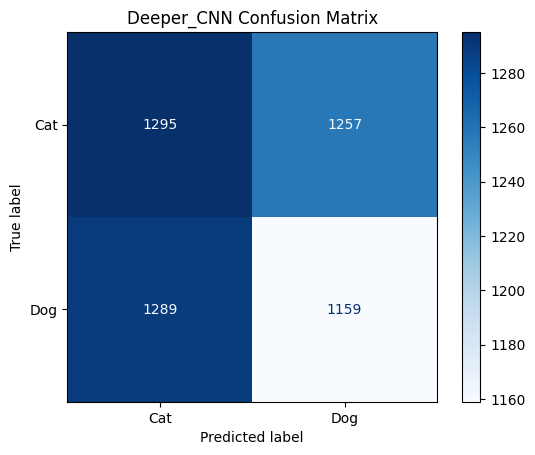

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


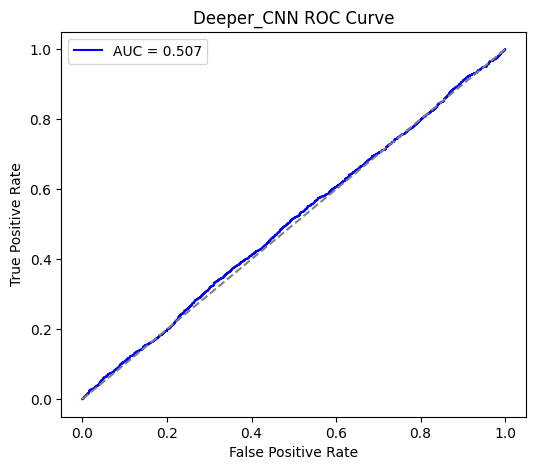

Training VGG16_Transfer...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.8469 - loss: 0.3221 - val_accuracy: 0.8918 - val_loss: 0.2427
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9121 - loss: 0.2037 - val_accuracy: 0.9124 - val_loss: 0.2057
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9179 - loss: 0.1913 - val_accuracy: 0.9156 - val_loss: 0.1990
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9310 - loss: 0.1655 - val_accuracy: 0.9156 - val_loss: 0.2059
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9418 - loss: 0.1471 - val_accuracy: 0.9208 - val_loss: 0.1961
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9464 - loss: 0.1334 - val_accuracy: 0.9192 - val_loss: 0.1952
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9509 - loss: 0.1219 - val_accuracy: 0.9090 - val_loss: 0.2343
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accurac

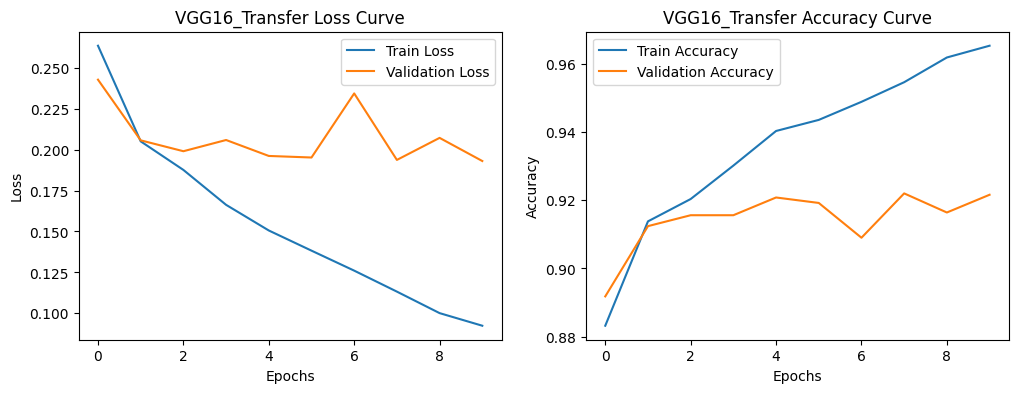

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


<Figure size 600x500 with 0 Axes>

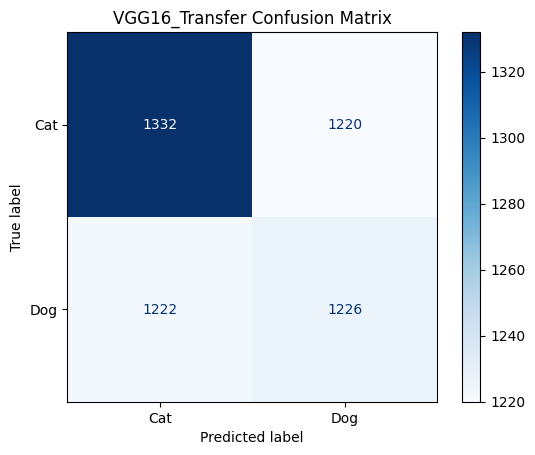

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


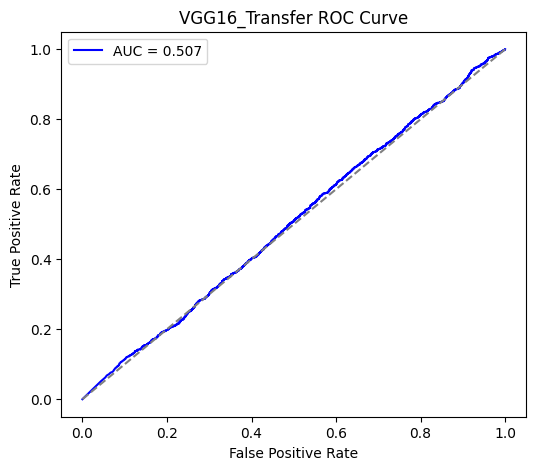

In [10]:
for name, model in models_list.items():
    print(f"Training {name}...")
    history = model.fit(train_generator, epochs=10, batch_size=32, validation_data=val_generator)
    history_dict[name] = history
    plot_training_history(history, name)
    plot_confusion_matrix(model, val_generator, name)
    plot_roc_curve(model, val_generator, name)

In [11]:
# 7. Predict on Test Set & Submit to Kaggle
simple_cnn_model = models_list["Simple_CNN"]
simple_cnn_predictions = simple_cnn_model.predict(test_images)

simple_cnn_submission_df = pd.DataFrame({
    "id": test_ids,
    "label": np.clip(simple_cnn_predictions.flatten(), 0, 1)
})

simple_cnn_submission_df = simple_cnn_submission_df.sort_values(by="id")
simple_cnn_submission_df.to_csv("simple_cnn_submission.csv", index=False)

deeper_cnn_model = models_list["Deeper_CNN"]
deeper_cnn_predictions = deeper_cnn_model.predict(test_images)

deeper_cnn_submission_df = pd.DataFrame({
    "id": test_ids,
    "label": np.clip(deeper_cnn_predictions.flatten(), 0, 1)
})

deeper_cnn_submission_df = deeper_cnn_submission_df.sort_values(by="id")
deeper_cnn_submission_df.to_csv("deeper_cnn_submission.csv", index=False)

vgg16_model = models_list["VGG16_Transfer"]
vgg16_predictions = vgg16_model.predict(test_images)

vgg16_submission_df = pd.DataFrame({
    "id": test_ids,
    "label": np.clip(vgg16_predictions.flatten(), 0, 1)
})

vgg16_submission_df = vgg16_submission_df.sort_values(by="id")
vgg16_submission_df.to_csv("vgg16_submission.csv", index=False)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


## Management/Research Question
- The goal of this project is to accurately classify images of dogs and cats using deep learning models. This capability is useful in various real-world applications, such as e-commerce, pet adoption platforms, and veterinary care.
- In online marketplaces and pet adoption sites, automated classification helps categorize pets correctly, making it easier for users to find what they are looking for. In veterinary medicine, identifying breeds from images can provide quick insights into potential health risks associated with specific breeds. Additionally, smart home security systems can use similar technology to distinguish between pets and intruders, reducing false alarms.
- Beyond classifying pets, the same deep learning techniques can be applied to other areas, such as wildlife monitoring, livestock management, and even medical imaging. Developing accurate models for dog vs. cat classification is a step toward improving broader image recognition tasks.

## Conclusion
- This study demonstrated that increasing model complexity and leveraging transfer learning can significantly improve classification performance. The Simple CNN, despite being a functional baseline, exhibited overfitting and suboptimal generalization. The Deeper CNN provided noticeable improvements, benefiting from additional layers and regularization techniques. However, the VGG16 Transfer Learning model emerged as the best-performing architecture, achieving the highest validation accuracy and Kaggle score.
- Future work may focus on further fine-tuning the VGG16 model by allowing more layers to be trainable, testing different optimization strategies such as SGD with momentum, and increasing dataset size to improve generalization. The results underscore the effectiveness of CNNs for image classification and highlight the advantages of transfer learning in enhancing model performance for real-world applications.